In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/SDSC Bootcamp

/content/drive/MyDrive/Colab Notebooks/SDSC Bootcamp


In [3]:
!pip install libpysal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 22.6 MB/s eta 0:00:00


In [4]:
!pip install contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 17.2 MB/s eta 0:00:00


In [5]:
!pip install splot


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.8/331.8 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.8/214.8 kB 15.2 MB/s eta 0:00:00


In [6]:
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import json
import seaborn as sns
import libpysal
import esda
from splot import esda as esdaplot



In [7]:
dc_census_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_11_tract.zip")


In [8]:
print(dc_census_tract.total_bounds)


[-77.119759  38.791645 -76.909393  38.995845]


In [9]:
# Define the bboxing of Washington, D.C.
dc_bbox = "38.791645,-77.119759,38.995845,-76.909393 "

In [10]:
# Define the Overpass API URL
overpass_url = "http://overpass-api.de/api/interpreter"

# Define the Overpass query using the bounding box variable
dc_eatery_overpass_query = f"""
[out:json][timeout:25];

(
  node["amenity"="restaurant"]({dc_bbox});
  node["amenity"="cafe"]({dc_bbox});
  node["amenity"="bar"]({dc_bbox});
  node["amenity"="biergarten"]({dc_bbox});
  node["amenity"="pub"]({dc_bbox});

);
out body;
>;
out skel qt;
"""

# Make the request
dc_eatery_response = requests.get(overpass_url, params={'data': dc_eatery_overpass_query})
dc_eatery_dict = dc_eatery_response.json()

# Convert the data into a pandas DataFrame
dc_eatery_list = [] # Create a list for the initilization of the dataframe
for element in dc_eatery_dict['elements']:
    latitude = element['lat']
    longitude = element['lon']
    name = element.get('tags', {}).get('name', 'n/a')
    amenity = element.get('tags', {}).get('amenity', 'n/a')
    dc_eatery_list.append({
        'Name': name,
        'Type': amenity,
        'Latitude': latitude,
        'Longitude': longitude
    })

# Create the DataFrame using the list
dc_eatery_df = pd.DataFrame(dc_eatery_list)

# Show the DataFrame
dc_eatery_df

,Name,Type,Latitude,Longitude
0,Cafe Saint Ex,bar,38.915421,-77.031701
1,Millie’s,restaurant,38.945050,-77.096330
2,Buzz Bakeshop,cafe,38.821596,-77.047646
3,Euro Market,cafe,38.891441,-77.086067
4,Mamma Lucia,restaurant,38.990991,-77.029690
...,...,...,...,...
2291,Donahue DC,restaurant,38.907631,-77.063620
2292,Georgetown Seafood,restaurant,38.905525,-77.065083
2293,Gong Cha,cafe,38.905273,-77.065405
2294,Officina Cafe,cafe,38.903914,-77.037518


In [11]:
dc_census_tract_rprj = dc_census_tract.to_crs("EPSG:26986")


In [12]:

# Create a GeoDataFrame for `dc_eatery_df`
dc_eatery_gdf = gpd.GeoDataFrame(dc_eatery_df.copy(), geometry=gpd.points_from_xy(dc_eatery_df.Longitude, dc_eatery_df.Latitude), crs = dc_census_tract.crs) #"EPSG:4326"

# Reproject the `dc_eatery_gdf` to match the CRS of the `dc_census_tract_rprj` GeoDataFrame
dc_eatery_gdf_prj = dc_eatery_gdf.to_crs(dc_census_tract_rprj.crs)

# Perform a spatial join between the reprojected eatery points and the census tracts.
# This assigns each eatery to a census tract if it is within the tract's boundaries.
dc_eatery = gpd.sjoin(dc_eatery_gdf_prj, dc_census_tract_rprj, predicate='within', how='inner').reset_index(drop = True)
dc_ct_eatery = dc_eatery.assign(count = np.ones(dc_eatery.shape[0]))
dc_ct_eatery = dc_ct_eatery.groupby('GEOID')['count'].sum().reset_index()

# Merge the eatery counts with the census tracts GeoDataFrame
dc_ct_pois = dc_census_tract_rprj.merge(dc_ct_eatery, on='GEOID', how='left')

# Replace NaN values with 0 for tracts without eatery
dc_ct_pois['count'] = dc_ct_pois['count'].fillna(0)

# Rename the 'count' column to 'eatery_count'
dc_ct_pois.rename(columns={'count': 'eatery_count'}, inplace=True)

In [ ]:
dc_ct_pois.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,eatery_count
0,11,001,004001,11001004001,40.01,Census Tract 40.01,G5020,S,271037,2414,+38.9208738,-077.0462674,"POLYGON ((-281740.816 534688.338, -281728.658 ...",6.0
1,11,001,004002,11001004002,40.02,Census Tract 40.02,G5020,S,194755,0,+38.9181186,-077.0437209,"POLYGON ((-281439.789 534119.408, -281439.514 ...",14.0
2,11,001,003600,11001003600,36,Census Tract 36,G5020,S,305616,0,+38.9236744,-077.0296273,"POLYGON ((-280161.821 535179.722, -280140.373 ...",1.0
3,11,001,004201,11001004201,42.01,Census Tract 42.01,G5020,S,204529,0,+38.9162076,-077.0388456,"POLYGON ((-281053.345 533856.364, -281048.509 ...",11.0
4,11,001,004202,11001004202,42.02,Census Tract 42.02,G5020,S,207646,0,+38.9134023,-077.0430254,"POLYGON ((-281426.435 533916.749, -281403.579 ...",19.0


<ipython-input-13-2f0206c3b04b>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', len(unique_types))  # Get the colormap


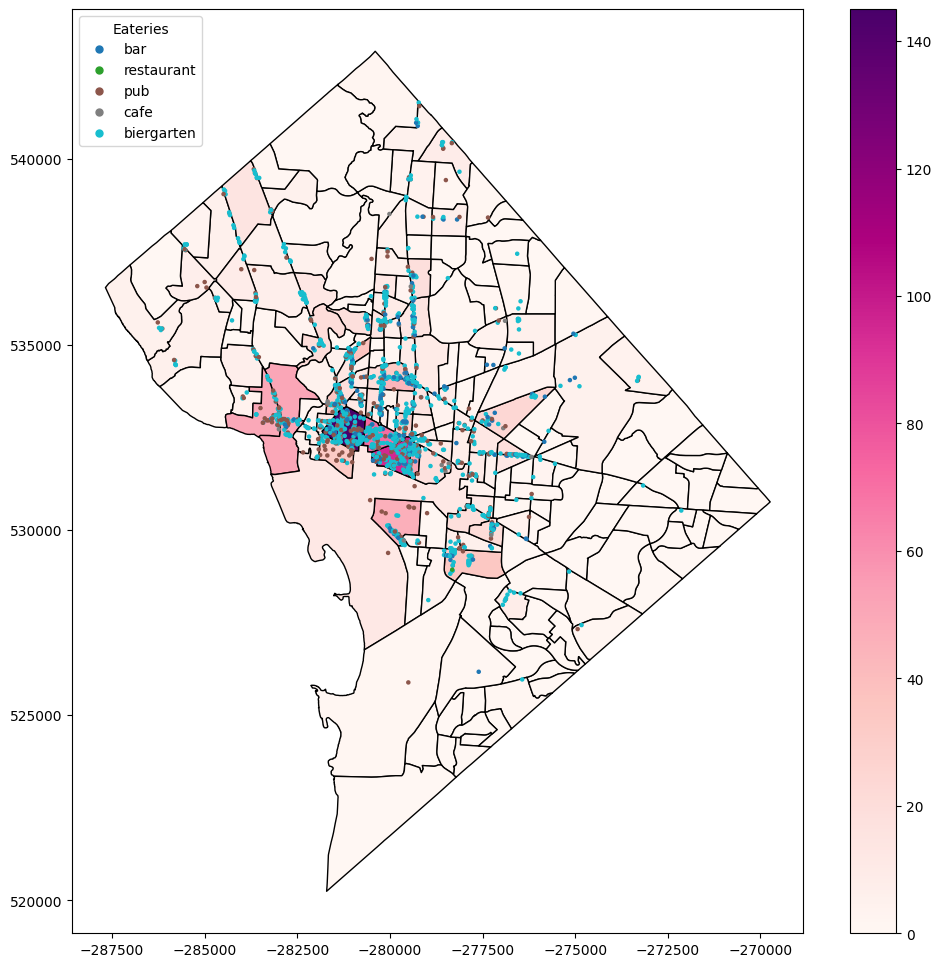

In [13]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(12,12))

# Plot the census tracts with color based on 'eatery_count'
dc_ct_pois.plot(ax=ax, column='eatery_count', legend=True, cmap='RdPu', linewidth=1, edgecolor='black')

# Plot the eateries with color based on 'Type'
dc_eatery.plot(ax=ax, marker='o', markersize=5, column='Type', legend=False, cmap='tab10')

# Get unique types and their corresponding colors from the colormap
unique_types = dc_eatery['Type'].unique()
cmap = cm.get_cmap('tab10', len(unique_types))  # Get the colormap
norm = Normalize(vmin=0, vmax=len(unique_types) - 1)  # Normalize for the number of unique types

# Create a legend entry for each unique type
legend_elements = [Line2D([0], [0], marker='o', color=cmap(norm(i)), lw=0, markersize=5, label=type) for i, type in enumerate(unique_types)]

# Add the legend for eateries
ax.legend(handles=legend_elements, loc='upper left', title='Eateries')

# Show the plot
plt.show()

Spatial Autocorrelation -- Eateries across census tracts in DC

In [14]:
# Create spatial weights matrix
w = libpysal.weights.Queen.from_dataframe(dc_ct_pois)


<ipython-input-14-dd88473eae9e>:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(dc_ct_pois)


In [ ]:
# Moran's I
moran = esda.moran.Moran(dc_ct_pois["eatery_count"], w)


In [ ]:
print("Moran's I:", moran.I)


Moran's I: 0.6361973228185239


/usr/local/lib/python3.10/dist-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


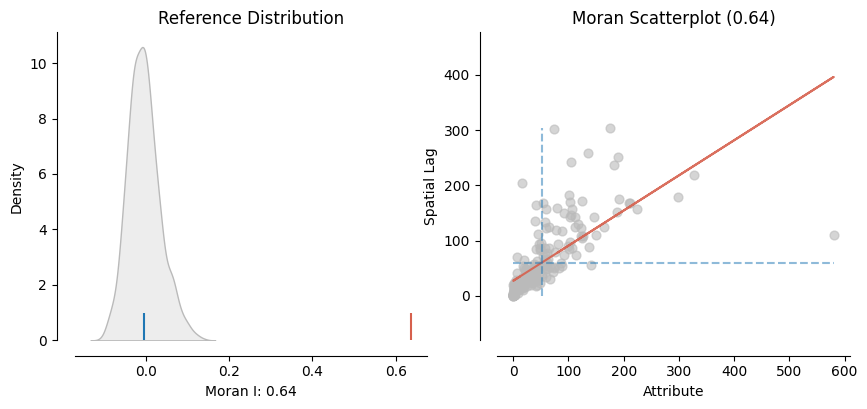

In [ ]:
#Moran's scatterplot
esdaplot.plot_moran(moran, dc_ct_pois);


In [ ]:
#Local Moran's I
local_moran = esda.moran.Moran_Local(dc_ct_pois['eatery_count'], w)


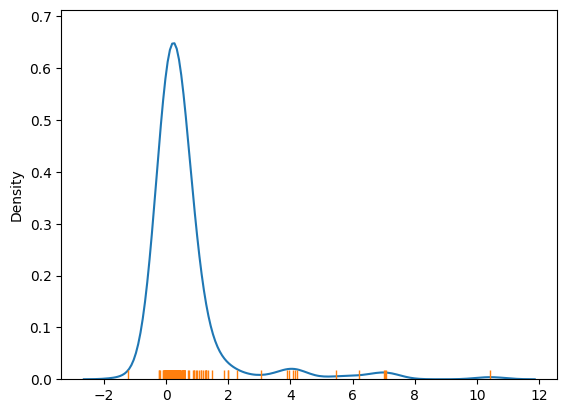

In [ ]:
#plotting Local Moran's I
ax = sns.kdeplot(local_moran.Is)
sns.rugplot(local_moran.Is, ax=ax);

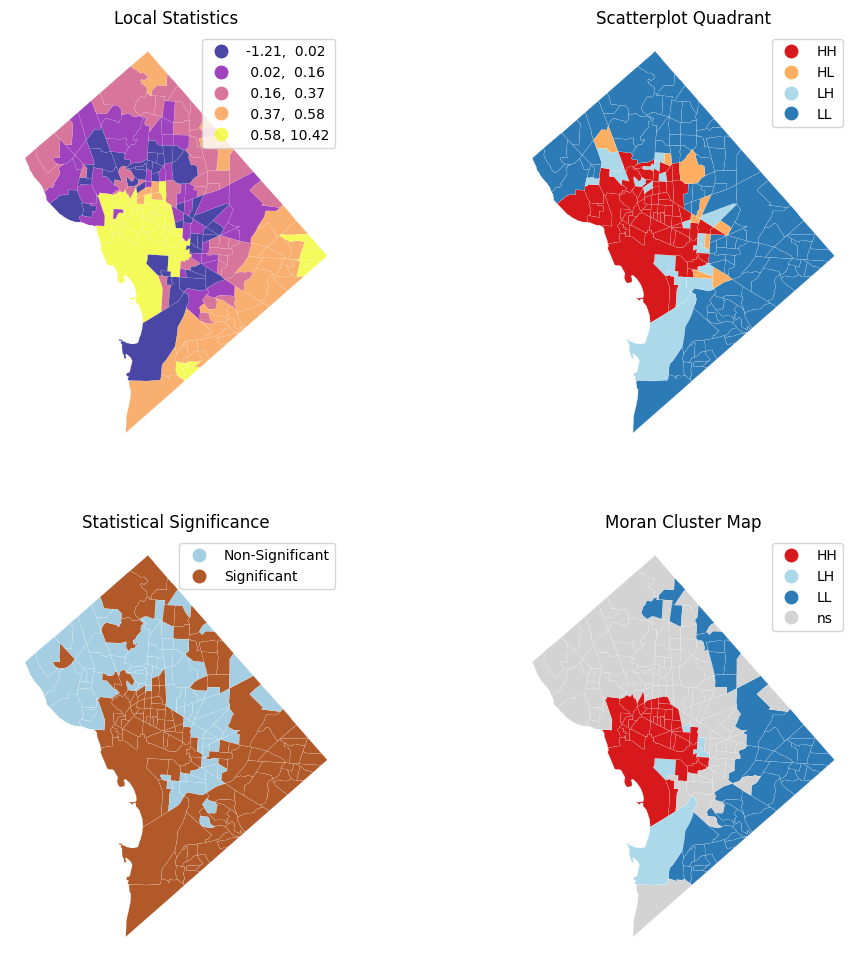

In [ ]:
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axs = axs.flatten()

# Subplot 1: Choropleth of local statistics
ax = axs[0]
dc_ct_pois.assign(Is=local_moran.Is).plot(column="Is", cmap="plasma", scheme="quantiles", k=5, edgecolor="white", linewidth=0.1, alpha=0.75, legend=True, ax=ax)

# Subplot 2: Quadrant categories
ax = axs[1]
esdaplot.lisa_cluster(local_moran, dc_ct_pois.to_crs(26986), p=1, ax=ax)

# Subplot 3: Significance map (alpha=0.10)
ax = axs[2]
labels = pd.Series(1 * (local_moran.p_sim < 0.10), index=dc_ct_pois.index).map({1: "Significant", 0: "Non-Significant"})
dc_ct_pois.assign(cl=labels).plot(column="cl", categorical=True, k=2, cmap="Paired", linewidth=0.1, edgecolor="white", legend=True, ax=ax)

# Subplot 4: Cluster map
ax = axs[3]
esdaplot.lisa_cluster(local_moran, dc_ct_pois.to_crs(26986), p=0.05, ax=ax)

# Figure styling #
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(["Local Statistics","Scatterplot Quadrant","Statistical Significance","Moran Cluster Map"][i]);

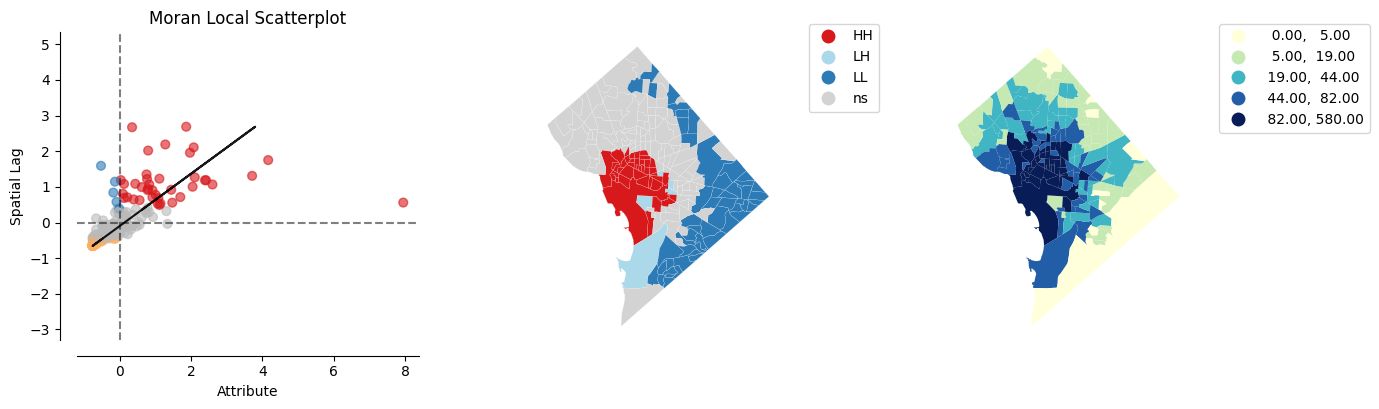

In [ ]:
#plot the Moran plot (showing significant clusters and outliers) next to the resulting Moran Cluster Map.
esdaplot.plot_local_autocorrelation(local_moran, dc_ct_pois, 'eatery_count', p=0.05);


In [ ]:
#detecting clusters and outliers
dc_ct_pois[['GEOID', 'eatery_count', 'geometry']].head()


,GEOID,eatery_count,geometry
0,11001004001,81.0,"POLYGON ((-281740.816 534688.338, -281728.658 ..."
1,11001004002,122.0,"POLYGON ((-281439.789 534119.408, -281439.514 ..."
2,11001003600,99.0,"POLYGON ((-280161.821 535179.722, -280140.373 ..."
3,11001004201,88.0,"POLYGON ((-281053.345 533856.364, -281048.509 ..."
4,11001004202,92.0,"POLYGON ((-281426.435 533916.749, -281403.579 ..."


In [ ]:
## Calculate the local Moran's I statistics and assign them along with their associated p-values and quadrants to each zone
local_moran = esda.moran.Moran_Local(dc_ct_pois['eatery_count'], w)
dc_ct_pois['local_moran_i'] = local_moran.Is
dc_ct_pois['local_moran_p_value'] = local_moran.p_sim
dc_ct_pois['local_moran_quadrant'] = local_moran.q

In [ ]:
# Get the statistically significant clusters and outliers at alpha = 0.10
alpha = 0.10
hotspots = dc_ct_pois.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots = dc_ct_pois.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts = dc_ct_pois.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds = dc_ct_pois.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")
not_significant = dc_ct_pois.query(f"local_moran_p_value >= {alpha}")

/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


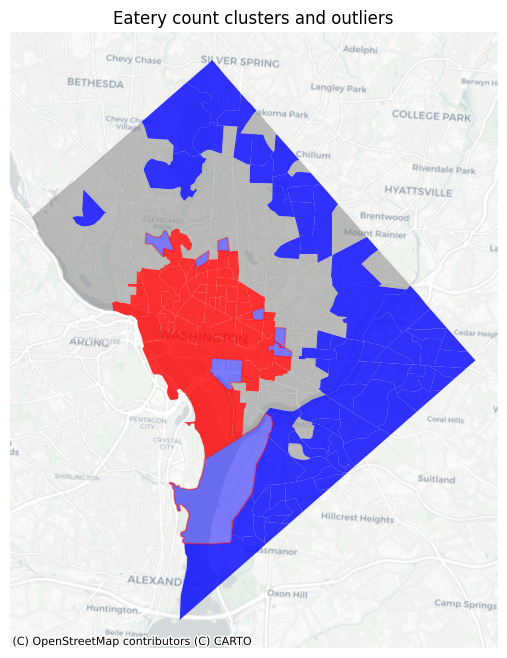

In [ ]:
# Plot the hot spots, cold spots, diamonds and doughnuts.
fig, ax = plt.subplots(figsize=(16,8))
hotspots.plot(color='red',alpha=0.8, ax=ax, label='Hot Spot')
coldspots.plot(color='blue', alpha=0.8, ax=ax, label='Cold Spot')
diamonds.plot(color='red', edgecolor='blue', alpha=0.5, ax=ax, label='Diamonds')
doughnuts.plot(color='blue', edgecolor='red', alpha=0.5, ax=ax, label='Doughnuts')
not_significant.plot(color='gray', alpha=0.5, label='Not Significant', ax=ax)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=26986)
ax.set_title('Eatery count clusters and outliers')
ax.axis('off');